# Choice of proposal distribution

We investigate the effect of the proposal distribution when learning an unnormalised model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


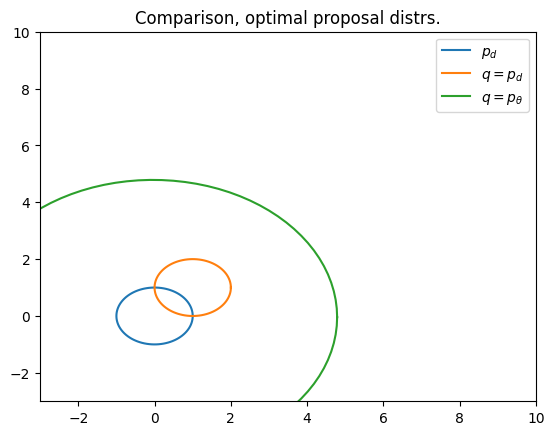

In [6]:
import sys
import torch
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt

sys.path.append("..")
from src.nce.cnce import CondNceCrit
from src.nce.rank import NceRankCrit

from src.noise_distr.normal import MultivariateNormal
from src.models.gaussian_model import DiagGaussianModel

from src.training.model_training import train_model, train_model_model_proposal
from src.data.normal import MultivariateNormalData
from src.training.training_utils import Mse, MvnKlDiv, no_change_stopping_condition, no_stopping
%load_ext autoreload
%autoreload 2

def mvn_curve(mu, cov, std=1, res=100):
    with torch.no_grad():
        angles = torch.linspace(0, 2*torch.pi, res)
        curve_param = torch.column_stack((torch.cos(angles), torch.sin(angles)))
        ellipsis = std * curve_param @ torch.Tensor(sqrtm(cov))
        return mu + ellipsis
    
def plot_mvn(levels, ax, label):
    ax.plot(levels[:, 0], levels[:, 1], label=label)

def plot_distrs_ideal(p_d, p_t_d, p_t_t):    
    fig, ax = plt.subplots()
    ax.set_xlim([-3, 10])
    ax.set_ylim([-3, 10])
    distrs = [
        (p_d.mu, p_d.cov, "$p_{d}}$"),
        (p_t_d.mu, p_t_d.cov(), "$q=p_d$"),
        (p_t_t.mu, p_t_t.cov(), "$q = p_{\\theta}$")
    ]
    for mu, cov, label in distrs:
        plot_mvn(mvn_curve(mu, cov), ax, label)
    ax.set_title("Comparison, optimal proposal distrs.")
    ax.legend()

def plot_distrs_adaptive(p_d, p_theta, q_phi):    
    fig, ax = plt.subplots()
    ax.set_xlim([-3, 10])
    ax.set_ylim([-3, 10])
    distrs = [
        (p_d.mu, p_d.cov, "$p_{d}}$"),
        (p_theta.mu, p_theta.cov(), "$p_{\\theta}$"),
        (q_phi.mu, q_phi.cov(), "$q_{\\varphi}$")
    ]
    for mu, cov, label in distrs:
        plot_mvn(mvn_curve(mu, cov), ax, label)
    ax.set_title("Adaptive proposal")
    ax.legend()

# Idealistic case

Assume that we can evaluate and sample from $p_d$ and $p_\theta$,
which is the better alternative as the proposal distribution $q$? 

Finished training


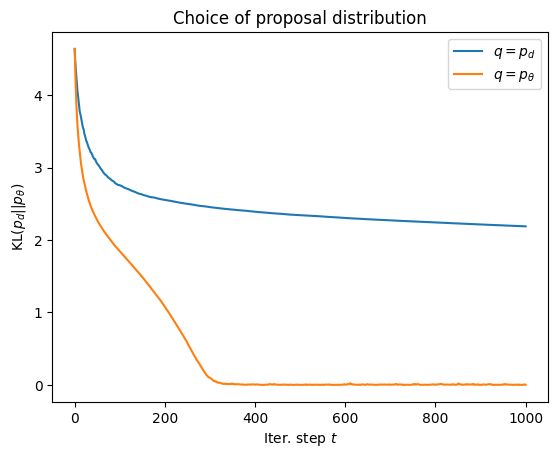

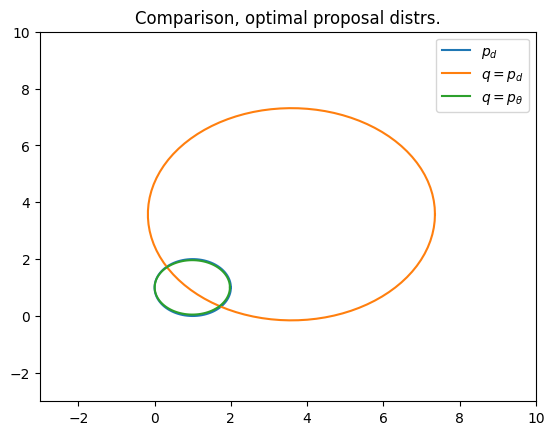

In [8]:
D, N, J = 2, 100, 10 # Dimension, Num. data samples, Num neg. samples
# Data model
mu_star, cov_star = torch.ones(D,), torch.eye(D)
p_d = MultivariateNormal(mu_star, cov_star)

init_mu, init_cov =5.0*torch.ones(D,), 4*torch.eye(D)

num_epochs = 200
batch_size = 20
learn_rate = 0.01*batch_size**0.5

training_data = MultivariateNormalData(mu_star, cov_star, N)
train_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)

# Metrics
kl_div = MvnKlDiv(p_d.mu, p_d.cov).metric
mse = Mse(p_d.mu).metric
metric = kl_div

# q = p_d
p_t_data_noise = DiagGaussianModel(init_mu.clone(), init_cov.clone())
criterion = NceRankCrit(p_t_data_noise, p_d, J)
p_d_losses, p_d_metrics = train_model(criterion,
                  metric,
                  train_loader,
                  None,
                  neg_sample_size=J,
                  num_epochs=num_epochs,
                  stopping_condition=no_change_stopping_condition,
                  lr=learn_rate)

# q = p_theta
p_t_model_noise = DiagGaussianModel(init_mu.clone(), init_cov.clone())
p_t_losses, p_t_metrics = train_model_model_proposal(p_t_model_noise,
                           NceRankCrit,
                           metric,
                           train_loader,
                           None,
                           J,
                           num_epochs,
                           lr=learn_rate)

fig, ax = plt.subplots()
ax.plot(torch.arange(p_d_metrics.size(0)), p_d_metrics, label="$q=p_d$")
ax.plot(torch.arange(p_t_metrics.size(0)), p_t_metrics, label="$q=p_{\\theta}$")
ax.legend();
ax.set_title("Choice of proposal distribution")
ax.set_xlabel("Iter. step $t$")
ax.set_ylabel("KL$(p_d || p_{\\theta})$");
plot_distrs_ideal(p_d, p_t_data_noise, p_t_model_noise)

# Adaptive proposal

Assume that we have a learnable proposal $q_\varphi$.
We jointly learn this proposal by minimising
$$
KL(p_\theta \| q_\varphi) \propto - \mathbb{E}_{x \sim p_\theta} \log q_\varphi(x) = \mathcal{L}_\varphi
$$
with,
$$
\nabla_\varphi \mathcal{L}_\varphi \approx \sum_{j=0}^J w(x_j) \nabla \log q_\varphi(x_j)
$$

tensor([[6.2415, 0.0000],
        [0.0000, 3.8538]], grad_fn=<DiagBackward0>)

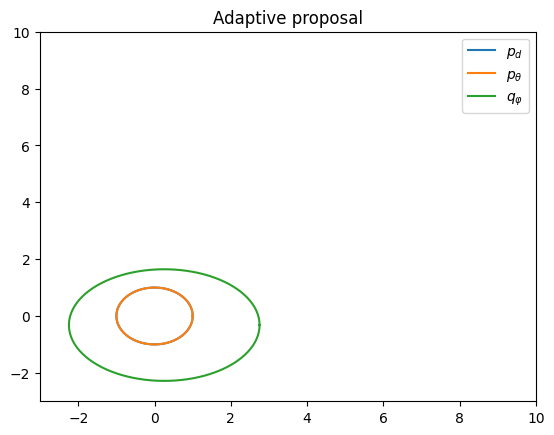

In [570]:
from src.nce.adaptive_rank import AdaptiveRankKernel
from src.noise_distr.adaptive import AdaptiveDiagGaussianModel


def train_model_adaptive_proposal(
    p_theta,
    q_phi,
    p_criterion,
    q_criterion,
    evaluation_metric,
    train_loader,
    save_dir,
    neg_sample_size,
    num_epochs,
    stopping_condition=no_stopping,
    lr: float = 0.1,
):
    """Training loop for adaptive proposal q_phi

    Training loop for jointly learning p_tilde_theta and q_phi.
    Where we assume that we can sample and evaluate q_phi.
    """
    p_optimizer = torch.optim.SGD(p_theta.parameters(), lr=lr)
    q_optimizer = torch.optim.SGD(q_phi.parameters(), lr=lr)
    batch_metrics = []
    batch_metrics.append(evaluation_metric(q_phi))
    batch_losses = []
    for epoch in range(1, num_epochs + 1):
        # print(f"Epoch {epoch}")
        old_params = torch.nn.utils.parameters_to_vector(q_phi.parameters())
        for _, (y, idx) in enumerate(train_loader, 0):
            q_optimizer.zero_grad()
            with torch.no_grad():
                p_loss = p_criterion.crit(y, None)
                batch_losses.append(p_loss.item())
            # Calculate and assign gradients
            # p_crit.calculate_crit_grad(y, idx)
            q_crit.calculate_crit_grad(y, idx)
            # Take gradient step
            # p_optimizer.step()
            q_optimizer.step()

            batch_metrics.append(evaluation_metric(q_phi))
        if stopping_condition(
            torch.nn.utils.parameters_to_vector(q_phi.parameters()), old_params
        ):
            print("Training converged")
            break
    return torch.tensor(batch_losses), torch.tensor(batch_metrics)

D, N, J = 2, 1000, 50 # Dimension, Num. data samples, Num neg. samples
# Data model
mu_star, cov_star = 0*torch.ones(D,), 1*torch.eye(D)
p_d = MultivariateNormal(mu_star, cov_star)

init_mu, init_cov = 0.0 * torch.ones(D,), 1 * torch.eye(D)
p_theta = DiagGaussianModel(init_mu.clone(), init_cov.clone())
q_phi = AdaptiveDiagGaussianModel(init_mu.clone(), 1.0*init_cov.clone())
p_crit = NceRankCrit(p_theta, q_phi, J)
q_crit = AdaptiveRankKernel(p_theta, q_phi, J)

num_epochs = 1000
batch_size = N
learn_rate = 0.001*batch_size**0.5

training_data = MultivariateNormalData(mu_star, cov_star, N)
train_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)

# Metrics
kl_div = MvnKlDiv(p_d.mu, p_d.cov).metric
mse = Mse(p_d.mu).metric
metric = kl_div

# q = p_d

p_d_losses, p_d_metrics = train_model_adaptive_proposal(p_theta,
                                                        q_phi,
                                                        p_crit,
                                                        q_crit,
                                                        metric,
                                                        train_loader,
                                                        None,
                                                        neg_sample_size=J,
                                                        num_epochs=num_epochs,
                                                        stopping_condition=no_change_stopping_condition,
                                                        lr=learn_rate)
plot_distrs_adaptive(p_d, p_theta, q_phi)
q_phi.cov()

In [552]:
q_phi.cov()

tensor([[ 0.6201,  0.0000],
        [ 0.0000, 28.4592]], grad_fn=<DiagBackward0>)

Gradient: $q_\phi = p_\theta$

In [697]:
import numpy as np
from src.part_fn_utils import concat_samples, norm_weights
N, J, D = 1, 3, 2
pi = np.pi
mu, cov = torch.zeros(D,), torch.eye(D)
p_theta = AdaptiveDiagGaussianModel(mu, cov)
q_phi = AdaptiveDiagGaussianModel(mu, cov)
q_crit = AdaptiveRankKernel(p_theta, q_phi, J)
y = torch.zeros((N, D))
y_samples = torch.zeros((N, J, D))
# y_samples = q_crit.sample_noise(J, y)
ys = concat_samples(y, y_samples)
# print(f"Init probs: p={p_theta.prob(ys)} q={q_phi.prob(ys)}")
ws = norm_weights(q_crit._unnorm_w(y, y_samples))
diag_deriv = 2 * torch.ones(D,)
exact_grad(ys, ws, mu, cov), q_phi.grad_log_prob(ys, ws)

torch.Size([2, 4])


((tensor([[0., 0.]], grad_fn=<PermuteBackward0>),
  tensor([[-0.5000,  0.0000],
          [ 0.0000, -0.5000]], grad_fn=<AddBackward0>)),
 [tensor([0., 0.]),
  tensor([[-0.5000,  0.0000],
          [ 0.0000, -0.5000]])])

In [703]:
def exact_grad(ys, ws, mu, cov):
    diff = (ys - mu).reshape((N+J, D)).T
    print(diff.shape)
    cov_inv = torch.linalg.inv(cov)
    emp_cov = (ws * diff) @ diff.T
    mu_deriv = (cov_inv @ diff) @ ws.T
    cov_deriv = - cov_inv / 2 + cov_inv @ emp_cov @ cov_inv / 2
    return mu_deriv.T, cov_deriv
ys.shape, mu.shape
diff = ys.reshape((N+J, D)).T - mu
diff.shape

RuntimeError: The size of tensor a (4) must match the size of tensor b (2) at non-singleton dimension 1

In [761]:
tmp = torch.arange(1, J+2)
tmp
yss = torch.column_stack((tmp.clone(), tmp.clone())).reshape((N, J+1, D))
# yss = torch.tensor([1, 2]).reshape(1, 1, D)
(yss-mu).reshape(N+J, D).T
diff.T @ cov_inv @ diff
(diff.T @ diff)

torch.Size([4, 4])

In [767]:
a = torch.ones(2,4)
b = torch.ones(2,4)
(a.T * b).sum()

RuntimeError: The size of tensor a (2) must match the size of tensor b (4) at non-singleton dimension 1

In [768]:
mu = torch.nn.Parameter(torch.ones(D,).clone(), requires_grad=True)
cov_inv = torch.linalg.inv(cov)
diff = (yss - mu).reshape((N+J, D)).T
l = - 1/2 * ((cov_inv @ diff) * diff).sum()
l.backward()
print(mu.grad, (cov_inv @ diff).T)


tensor([6., 6.]) tensor([[0., 0.],
        [1., 1.],
        [2., 2.],
        [3., 3.]], grad_fn=<PermuteBackward0>)
